In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_massver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'train_mass_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_massver', 'train_mass_FN.npy'))
    return images, labels#, FN


def load_testing():
    images = np.load(os.path.join('../Data_final_massver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'test_mass_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_massver', 'test_mass_FN.npy'))
    return images, labels#, FN

In [3]:
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1390 	 Test size: 306
Image size: 256x256


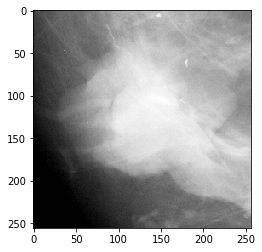

Label: 1


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
#print("FN: " + str(test_FN[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(1390, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_resnet101(verbose=False, fc_size=256, output = 2, dropout=None):
    
    resnet101_base = ResNet101(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet101 = models.Sequential()
    resnet101.add(resnet101_base)

    resnet101.add(layers.Flatten())
    if dropout is not None:
        resnet101.add(layers.Dropout(dropout))
    resnet101.add(layers.Dense(fc_size, activation='relu'))
    resnet101.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    resnet101_base.trainable = False
    
    if verbose:
        resnet101_base.summary()
        resnet101.summary()

    return resnet101

In [12]:
resnet = ResNet101(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in resnet.layers:
    layer.trainable = False
resnet_maxpool = resnet.get_layer('conv5_block3_out').output
FeatureFlatten = Flatten()(resnet_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_resnet = Model(inputs = resnet.input, outputs = predictions)
new_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
resnet101_mass_benign_or_malignant_best_Adam = new_resnet

In [14]:
resnet101_mass_benign_or_malignant_best_RMSprop = new_resnet

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_mass_benign_or_malignant_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_mass_benign_or_malignant_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_resnet101_mass_benign_or_malignant_best_Adam = resnet101_mass_benign_or_malignant_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 3.6734 - recall: 0.5215
Epoch 00001: val_loss improved from inf to 0.76205, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 18s 4s/step - loss: 3.1926 - recall: 0.5328 - val_loss: 0.7620 - val_recall: 0.5576
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8808 - recall: 0.5703
Epoch 00002: val_loss improved from 0.76205 to 0.62977, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 13s 3s/step - loss: 0.8568 - recall: 0.5719 - val_loss: 0.6298 - val_recall: 0.6115
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6886 - recall: 0.6133
Epoch 00003: val_loss did not improve from 0.62977
5/5 [=====

In [17]:
models.save_model(resnet101_mass_benign_or_malignant_best_Adam, '../model/resnet101_mass_benign_or_malignant_end_Adam.h5')

In [18]:
tra_loss_fe = history_resnet101_mass_benign_or_malignant_best_Adam.history['loss']
tra_acc_fe = history_resnet101_mass_benign_or_malignant_best_Adam.history['recall']
val_loss_fe = history_resnet101_mass_benign_or_malignant_best_Adam.history['val_loss']
val_acc_fe = history_resnet101_mass_benign_or_malignant_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_mass_benign_or_malignant = models.load_model('../model/resnet101_mass_benign_or_malignant_best_Adam.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("resnet101 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 benign or malignant

Epoch [end]: 36
Epoch [opt]: 6
Valid recall [end]: 0.6223
Valid recall [opt]: 0.6799
Test recall [end]:  0.5752
Test recall [opt]:  0.6536
Valid loss [end]: 0.7005
Valid loss [opt]: 0.5924
Test loss [end]:  0.7466
Test loss [opt]:  0.6349


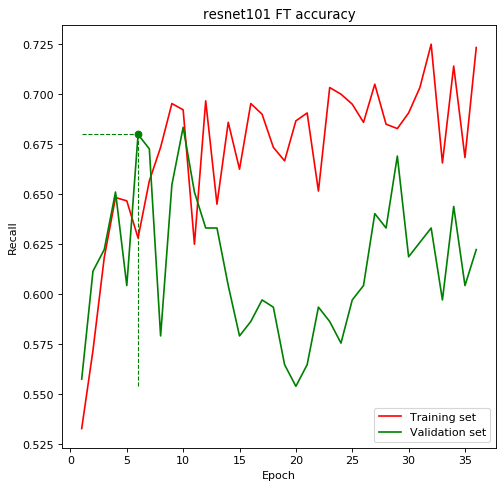

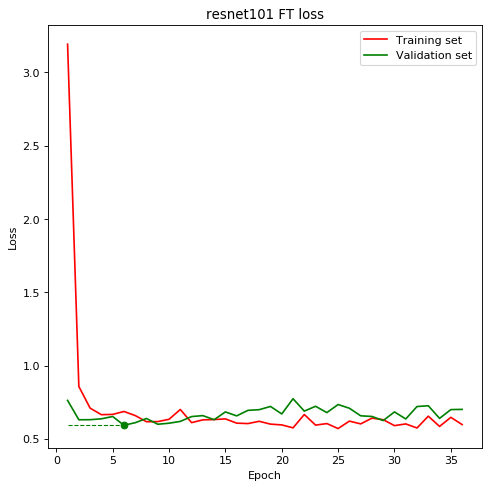

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [22]:
resnet101_mass_benign_or_malignant_best_SGD = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_mass_benign_or_malignant_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_mass_benign_or_malignant_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_resnet101_mass_benign_or_malignant_best_SGD = resnet101_mass_benign_or_malignant_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.6627 - recall: 0.5117
Epoch 00001: val_loss improved from inf to 1.05193, saving model to ../model/resnet101_mass_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 14s 3s/step - loss: 1.6126 - recall: 0.5141 - val_loss: 1.0519 - val_recall: 0.4784
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4461 - recall: 0.5371
Epoch 00002: val_loss improved from 1.05193 to 1.04782, saving model to ../model/resnet101_mass_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 11s 2s/step - loss: 1.4697 - recall: 0.5203 - val_loss: 1.0478 - val_recall: 0.4640
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5784 - recall: 0.5000
Epoch 00003: val_loss improved from 1.04782 to 0.92911, saving model to ../model/resnet101_mass_benign_or_malignant_best_SGD.h5
5/5 [======

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0259 - recall: 0.5508
Epoch 00029: val_loss did not improve from 0.76307
5/5 [==============================] - 10s 2s/step - loss: 1.0356 - recall: 0.5600 - val_loss: 0.8004 - val_recall: 0.5504
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0755 - recall: 0.5657
Epoch 00030: val_loss improved from 0.76307 to 0.72116, saving model to ../model/resnet101_mass_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 11s 2s/step - loss: 1.0676 - recall: 0.5600 - val_loss: 0.7212 - val_recall: 0.5647
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9468 - recall: 0.5890
Epoch 00031: val_loss did not improve from 0.72116
5/5 [==============================] - 10s 2s/step - loss: 0.9805 - recall: 0.5700 - val_loss: 0.7595 - val_recall: 0.5540
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0409 - recall: 0.5547
Epoch 00032: val_loss did not imp

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8649 - recall: 0.5664
Epoch 00059: val_loss did not improve from 0.68573
5/5 [==============================] - 10s 2s/step - loss: 0.8634 - recall: 0.5594 - val_loss: 0.7399 - val_recall: 0.5971
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8447 - recall: 0.6102
Epoch 00060: val_loss did not improve from 0.68573
5/5 [==============================] - 11s 2s/step - loss: 0.8865 - recall: 0.5783 - val_loss: 0.7286 - val_recall: 0.5360
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8753 - recall: 0.5977
Epoch 00061: val_loss did not improve from 0.68573
5/5 [==============================] - 10s 2s/step - loss: 0.8446 - recall: 0.6083 - val_loss: 0.7231 - val_recall: 0.5791
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7798 - recall: 0.6165
Epoch 00062: val_loss did not improve from 0.68573
5/5 [==============================] - 10s 2s/step - loss: 

Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7616 - recall: 0.6172
Epoch 00090: val_loss did not improve from 0.68455
5/5 [==============================] - 10s 2s/step - loss: 0.7856 - recall: 0.6000 - val_loss: 0.7012 - val_recall: 0.5791
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8420 - recall: 0.5664
Epoch 00091: val_loss did not improve from 0.68455
5/5 [==============================] - 10s 2s/step - loss: 0.8268 - recall: 0.5672 - val_loss: 0.7368 - val_recall: 0.5576
Epoch 92/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8121 - recall: 0.5918
Epoch 00092: val_loss did not improve from 0.68455
5/5 [==============================] - 10s 2s/step - loss: 0.7945 - recall: 0.5967 - val_loss: 0.8016 - val_recall: 0.5432
Epoch 93/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7353 - recall: 0.6144
Epoch 00093: val_loss did not improve from 0.68455
5/5 [==============================] - 10s 2s/step - loss: 

4/5 [=======================>......] - ETA: 1s - loss: 0.7255 - recall: 0.6017
Epoch 00150: val_loss did not improve from 0.65173
5/5 [==============================] - 11s 2s/step - loss: 0.7310 - recall: 0.6083 - val_loss: 0.6677 - val_recall: 0.5827
Epoch 151/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7100 - recall: 0.6094
Epoch 00151: val_loss did not improve from 0.65173
5/5 [==============================] - 10s 2s/step - loss: 0.7131 - recall: 0.6109 - val_loss: 0.6741 - val_recall: 0.5935
Epoch 152/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7631 - recall: 0.5859
Epoch 00152: val_loss did not improve from 0.65173
5/5 [==============================] - 11s 2s/step - loss: 0.7448 - recall: 0.5906 - val_loss: 0.6943 - val_recall: 0.5719
Epoch 153/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7769 - recall: 0.5469
Epoch 00153: val_loss did not improve from 0.65173
5/5 [==============================] - 11s 2s/step - loss: 0.7734 - r

Epoch 211/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7040 - recall: 0.6356
Epoch 00211: val_loss did not improve from 0.60963
5/5 [==============================] - 10s 2s/step - loss: 0.6961 - recall: 0.6317 - val_loss: 0.6859 - val_recall: 0.5827
Epoch 212/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7030 - recall: 0.6059
Epoch 00212: val_loss did not improve from 0.60963
5/5 [==============================] - 10s 2s/step - loss: 0.7223 - recall: 0.5900 - val_loss: 0.6474 - val_recall: 0.5863
Epoch 213/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7400 - recall: 0.5996
Epoch 00213: val_loss did not improve from 0.60963
5/5 [==============================] - 10s 2s/step - loss: 0.7094 - recall: 0.6200 - val_loss: 0.6899 - val_recall: 0.5755
Epoch 214/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6590 - recall: 0.6113
Epoch 00214: val_loss did not improve from 0.60963
5/5 [==============================] - 10s 2s/step - lo

In [24]:
models.save_model(resnet101_mass_benign_or_malignant_best_SGD, '../model/resnet101_mass_benign_or_malignant_end_SGD.h5')

In [25]:
tra_loss_fe = history_resnet101_mass_benign_or_malignant_best_SGD.history['loss']
tra_acc_fe = history_resnet101_mass_benign_or_malignant_best_SGD.history['recall']
val_loss_fe = history_resnet101_mass_benign_or_malignant_best_SGD.history['val_loss']
val_acc_fe = history_resnet101_mass_benign_or_malignant_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_mass_benign_or_malignant = models.load_model('../model/resnet101_mass_benign_or_malignant_best_SGD.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet101 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 benign or malignant

Epoch [end]: 215
Epoch [opt]: 185
Valid recall [end]: 0.6295
Valid recall [opt]: 0.6475
Test recall [end]:  0.6013
Test recall [opt]:  0.5948
Valid loss [end]: 0.6415
Valid loss [opt]: 0.6096
Test loss [end]:  0.6945
Test loss [opt]:  0.7040


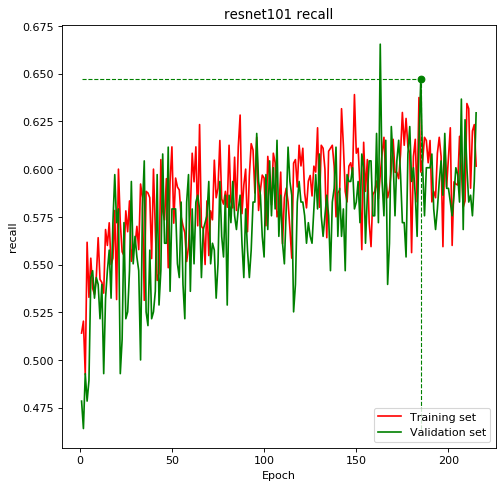

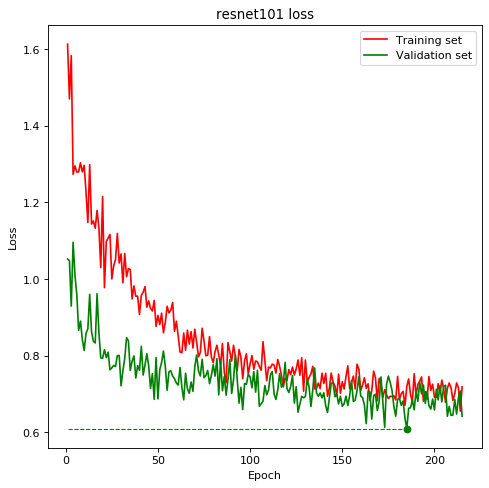

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_mass_benign_or_malignant_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_mass_benign_or_malignant_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [28]:
# Train
history_resnet101_mass_benign_or_malignant_best_RMSprop = resnet101_mass_benign_or_malignant_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 4.2645 - recall: 0.5699
Epoch 00001: val_loss improved from inf to 0.95516, saving model to ../model/resnet101_mass_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 16s 3s/step - loss: 4.3889 - recall: 0.5400 - val_loss: 0.9552 - val_recall: 0.4892
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 2.0813 - recall: 0.5215
Epoch 00002: val_loss did not improve from 0.95516
5/5 [==============================] - 10s 2s/step - loss: 1.9671 - recall: 0.5283 - val_loss: 1.2622 - val_recall: 0.5144
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5756 - recall: 0.5352
Epoch 00003: val_loss improved from 0.95516 to 0.68387, saving model to ../model/resnet101_mass_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 13s 3s/step - loss: 1.4643 - recall: 0.53

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5299 - recall: 0.7267
Epoch 00059: val_loss did not improve from 0.55135
5/5 [==============================] - 10s 2s/step - loss: 0.5412 - recall: 0.7217 - val_loss: 0.6162 - val_recall: 0.6799
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6955 - recall: 0.6504
Epoch 00060: val_loss did not improve from 0.55135
5/5 [==============================] - 10s 2s/step - loss: 0.7366 - recall: 0.6383 - val_loss: 0.7674 - val_recall: 0.6079
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6442 - recall: 0.6719
Epoch 00061: val_loss did not improve from 0.55135
5/5 [==============================] - 10s 2s/step - loss: 0.6213 - recall: 0.6812 - val_loss: 0.6016 - val_recall: 0.6403
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5509 - recall: 0.7500
Epoch 00062: val_loss did not improve from 0.55135
5/5 [==============================] - 11s 2s/step - loss: 

In [29]:
models.save_model(resnet101_mass_benign_or_malignant_best_RMSprop, '../model/resnet101_mass_benign_or_malignant_end_RMSprop.h5')

In [30]:
tra_loss_fe = history_resnet101_mass_benign_or_malignant_best_RMSprop.history['loss']
tra_acc_fe = history_resnet101_mass_benign_or_malignant_best_RMSprop.history['recall']
val_loss_fe = history_resnet101_mass_benign_or_malignant_best_RMSprop.history['val_loss']
val_acc_fe = history_resnet101_mass_benign_or_malignant_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_mass_benign_or_malignant = models.load_model('../model/resnet101_mass_benign_or_malignant_best_RMSprop.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet101 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 benign or malignant

Epoch [end]: 63
Epoch [opt]: 33
Valid recall [end]: 0.5683
Valid recall [opt]: 0.6906
Test recall [end]:  0.4967
Test recall [opt]:  0.6569
Valid loss [end]: 0.8121
Valid loss [opt]: 0.5514
Test loss [end]:  0.8720
Test loss [opt]:  0.6263


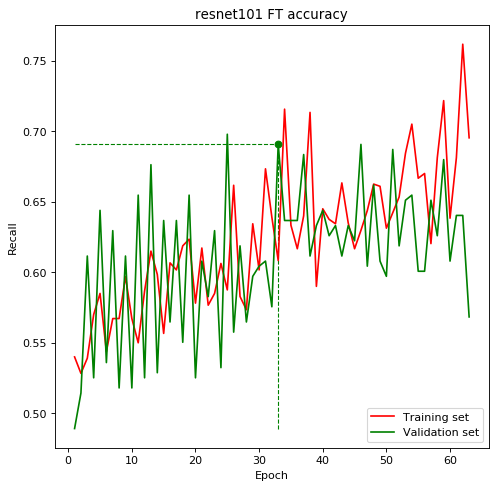

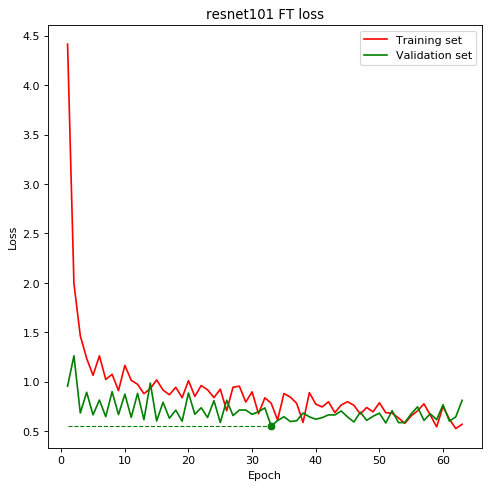

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [32]:
resnet101_mass_benign_or_malignant_best_Adadelta = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_mass_benign_or_malignant_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_mass_benign_or_malignant_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [33]:
# Train
history_resnet101_mass_benign_or_malignant_best_Adadelta = resnet101_mass_benign_or_malignant_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 2.3700 - recall: 0.4609
Epoch 00001: val_loss improved from inf to 1.11297, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 15s 3s/step - loss: 2.4393 - recall: 0.4531 - val_loss: 1.1130 - val_recall: 0.5036
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 2.2653 - recall: 0.5021
Epoch 00002: val_loss improved from 1.11297 to 1.06786, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 10s 2s/step - loss: 2.2831 - recall: 0.4950 - val_loss: 1.0679 - val_recall: 0.4748
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 2.3025 - recall: 0.4609
Epoch 00003: val_loss improved from 1.06786 to 0.99674, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adadelta

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 1.6040 - recall: 0.4640
Epoch 00029: val_loss did not improve from 0.84503
5/5 [==============================] - 10s 2s/step - loss: 1.6339 - recall: 0.4667 - val_loss: 1.0391 - val_recall: 0.4640
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.6161 - recall: 0.4414
Epoch 00030: val_loss did not improve from 0.84503
5/5 [==============================] - 10s 2s/step - loss: 1.6146 - recall: 0.4500 - val_loss: 0.8796 - val_recall: 0.4928
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5109 - recall: 0.4922
Epoch 00031: val_loss did not improve from 0.84503
5/5 [==============================] - 11s 2s/step - loss: 1.4562 - recall: 0.4969 - val_loss: 0.9420 - val_recall: 0.4604
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5836 - recall: 0.4852
Epoch 00032: val_loss did not improve from 0.84503
5/5 [==============================] - 11s 2s/step - loss: 

Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4800 - recall: 0.4863
Epoch 00060: val_loss did not improve from 0.84328
5/5 [==============================] - 10s 2s/step - loss: 1.4720 - recall: 0.5016 - val_loss: 0.9360 - val_recall: 0.4748
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4209 - recall: 0.5195
Epoch 00061: val_loss did not improve from 0.84328
5/5 [==============================] - 10s 2s/step - loss: 1.4075 - recall: 0.5156 - val_loss: 0.9627 - val_recall: 0.4424
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2050 - recall: 0.5614
Epoch 00062: val_loss did not improve from 0.84328
5/5 [==============================] - 11s 2s/step - loss: 1.1812 - recall: 0.5717 - val_loss: 1.0156 - val_recall: 0.4568
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3600 - recall: 0.5059
Epoch 00063: val_loss did not improve from 0.84328
5/5 [==============================] - 10s 2s/step - loss: 

4/5 [=======================>......] - ETA: 1s - loss: 1.2746 - recall: 0.5137
Epoch 00120: val_loss did not improve from 0.70888
5/5 [==============================] - 10s 2s/step - loss: 1.2780 - recall: 0.5078 - val_loss: 0.9712 - val_recall: 0.4676
Epoch 121/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5523 - recall: 0.5059
Epoch 00121: val_loss did not improve from 0.70888
5/5 [==============================] - 11s 2s/step - loss: 1.4561 - recall: 0.5078 - val_loss: 0.8902 - val_recall: 0.4532
Epoch 122/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3669 - recall: 0.4958
Epoch 00122: val_loss did not improve from 0.70888
5/5 [==============================] - 11s 2s/step - loss: 1.3967 - recall: 0.4950 - val_loss: 0.7812 - val_recall: 0.5252
Epoch 123/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3222 - recall: 0.5195
Epoch 00123: val_loss did not improve from 0.70888
5/5 [==============================] - 10s 2s/step - loss: 1.2932 - r

In [34]:
models.save_model(resnet101_mass_benign_or_malignant_best_Adadelta, '../model/resnet101_mass_benign_or_malignant_end_Adadelta.h5')

In [35]:
tra_loss_fe = history_resnet101_mass_benign_or_malignant_best_Adadelta.history['loss']
tra_acc_fe = history_resnet101_mass_benign_or_malignant_best_Adadelta.history['recall']
val_loss_fe = history_resnet101_mass_benign_or_malignant_best_Adadelta.history['val_loss']
val_acc_fe = history_resnet101_mass_benign_or_malignant_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_mass_benign_or_malignant = models.load_model('../model/resnet101_mass_benign_or_malignant_best_Adadelta.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet101 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 benign or malignant

Epoch [end]: 142
Epoch [opt]: 112
Valid recall [end]: 0.4784
Valid recall [opt]: 0.5396
Test recall [end]:  0.4739
Test recall [opt]:  0.4706
Valid loss [end]: 0.8337
Valid loss [opt]: 0.7089
Test loss [end]:  0.8516
Test loss [opt]:  0.8571


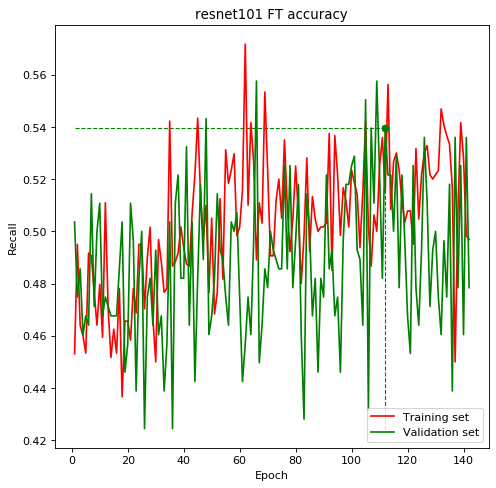

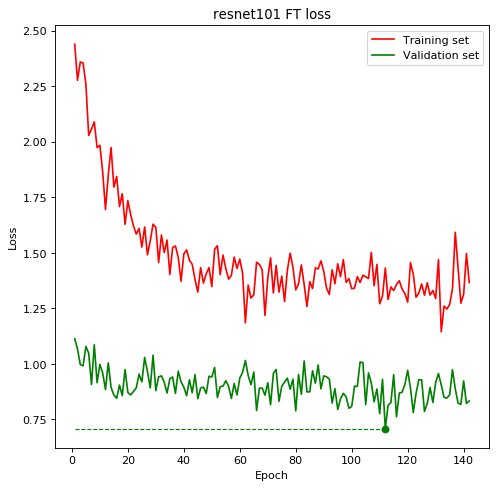

In [36]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [37]:
resnet101_mass_benign_or_malignant_best_Adagrad = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_mass_benign_or_malignant_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_mass_benign_or_malignant_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [38]:
# Train
history_resnet101_mass_benign_or_malignant_best_Adagrad = resnet101_mass_benign_or_malignant_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.4493 - recall: 0.5098
Epoch 00001: val_loss improved from inf to 1.25255, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 14s 3s/step - loss: 1.4110 - recall: 0.5141 - val_loss: 1.2525 - val_recall: 0.4820
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3878 - recall: 0.4936
Epoch 00002: val_loss improved from 1.25255 to 1.15076, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 10s 2s/step - loss: 1.4102 - recall: 0.4933 - val_loss: 1.1508 - val_recall: 0.5072
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3228 - recall: 0.5059
Epoch 00003: val_loss improved from 1.15076 to 1.13938, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adagrad.h5

4/5 [=======================>......] - ETA: 1s - loss: 0.8284 - recall: 0.5898
Epoch 00028: val_loss did not improve from 0.68792
5/5 [==============================] - 11s 2s/step - loss: 0.7921 - recall: 0.6125 - val_loss: 0.7500 - val_recall: 0.6007
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8678 - recall: 0.5547
Epoch 00029: val_loss did not improve from 0.68792
5/5 [==============================] - 11s 2s/step - loss: 0.8421 - recall: 0.5641 - val_loss: 0.6992 - val_recall: 0.5935
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8680 - recall: 0.5742
Epoch 00030: val_loss did not improve from 0.68792
5/5 [==============================] - 10s 2s/step - loss: 0.8562 - recall: 0.5859 - val_loss: 0.7321 - val_recall: 0.5576
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7209 - recall: 0.6229
Epoch 00031: val_loss did not improve from 0.68792
5/5 [==============================] - 11s 2s/step - loss: 0.7396 - reca

4/5 [=======================>......] - ETA: 1s - loss: 0.7114 - recall: 0.5918
Epoch 00088: val_loss did not improve from 0.61986
5/5 [==============================] - 10s 2s/step - loss: 0.6962 - recall: 0.6156 - val_loss: 0.6839 - val_recall: 0.5971
Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6849 - recall: 0.6113
Epoch 00089: val_loss did not improve from 0.61986
5/5 [==============================] - 11s 2s/step - loss: 0.6888 - recall: 0.6078 - val_loss: 0.6723 - val_recall: 0.6043
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7471 - recall: 0.6035
Epoch 00090: val_loss did not improve from 0.61986
5/5 [==============================] - 11s 2s/step - loss: 0.7413 - recall: 0.5984 - val_loss: 0.6886 - val_recall: 0.5863
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7092 - recall: 0.5953
Epoch 00091: val_loss did not improve from 0.61986
5/5 [==============================] - 11s 2s/step - loss: 0.6876 - reca

In [39]:
models.save_model(resnet101_mass_benign_or_malignant_best_Adagrad, '../model/resnet101_mass_benign_or_malignant_end_Adagrad.h5')

In [40]:
tra_loss_fe = history_resnet101_mass_benign_or_malignant_best_Adagrad.history['loss']
tra_acc_fe = history_resnet101_mass_benign_or_malignant_best_Adagrad.history['recall']
val_loss_fe = history_resnet101_mass_benign_or_malignant_best_Adagrad.history['val_loss']
val_acc_fe = history_resnet101_mass_benign_or_malignant_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_mass_benign_or_malignant = models.load_model('../model/resnet101_mass_benign_or_malignant_best_Adagrad.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet101 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 benign or malignant

Epoch [end]: 117
Epoch [opt]: 87
Valid recall [end]: 0.6187
Valid recall [opt]: 0.6511
Test recall [end]:  0.6307
Test recall [opt]:  0.6405
Valid loss [end]: 0.6629
Valid loss [opt]: 0.6199
Test loss [end]:  0.6614
Test loss [opt]:  0.6636


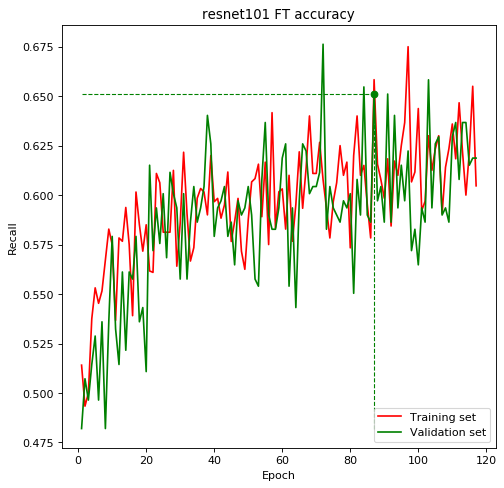

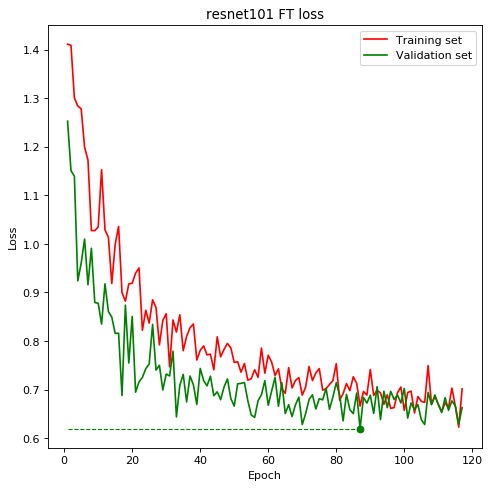

In [41]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [42]:
resnet101_mass_benign_or_malignant_best_Adamax = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_mass_benign_or_malignant_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_mass_benign_or_malignant_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [43]:
# Train
history_resnet101_mass_benign_or_malignant_best_Adamax = resnet101_mass_benign_or_malignant_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 3.5821 - recall: 0.5195
Epoch 00001: val_loss improved from inf to 2.40718, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 15s 3s/step - loss: 3.4096 - recall: 0.5109 - val_loss: 2.4072 - val_recall: 0.5144
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2310 - recall: 0.5339
Epoch 00002: val_loss improved from 2.40718 to 0.76386, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1537 - recall: 0.5550 - val_loss: 0.7639 - val_recall: 0.5432
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9158 - recall: 0.5636
Epoch 00003: val_loss improved from 0.76386 to 0.69363, saving model to ../model/resnet101_mass_benign_or_malignant_best_Adamax.h5
5/

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6433 - recall: 0.6172
Epoch 00028: val_loss did not improve from 0.64640
5/5 [==============================] - 11s 2s/step - loss: 0.6274 - recall: 0.6300 - val_loss: 0.6561 - val_recall: 0.5791
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6115 - recall: 0.6445
Epoch 00029: val_loss did not improve from 0.64640
5/5 [==============================] - 11s 2s/step - loss: 0.6052 - recall: 0.6484 - val_loss: 0.6504 - val_recall: 0.5827
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6044 - recall: 0.6562
Epoch 00030: val_loss did not improve from 0.64640
5/5 [==============================] - 10s 2s/step - loss: 0.6133 - recall: 0.6547 - val_loss: 0.6508 - val_recall: 0.6223
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6213 - recall: 0.6568
Epoch 00031: val_loss improved from 0.64640 to 0.63660, saving model to ../model/resnet101_mass_benign_or_mali

Epoch 58/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5939 - recall: 0.6680
Epoch 00058: val_loss did not improve from 0.58740
5/5 [==============================] - 11s 2s/step - loss: 0.5969 - recall: 0.6672 - val_loss: 0.5989 - val_recall: 0.6835
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5895 - recall: 0.7034
Epoch 00059: val_loss did not improve from 0.58740
5/5 [==============================] - 11s 2s/step - loss: 0.5920 - recall: 0.6917 - val_loss: 0.6072 - val_recall: 0.6691
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5914 - recall: 0.6914
Epoch 00060: val_loss did not improve from 0.58740
5/5 [==============================] - 10s 2s/step - loss: 0.5989 - recall: 0.6922 - val_loss: 0.6214 - val_recall: 0.6439
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6148 - recall: 0.6504
Epoch 00061: val_loss did not improve from 0.58740
5/5 [==============================] - 11s 2s/step - loss: 

Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5760 - recall: 0.7119
Epoch 00089: val_loss did not improve from 0.58173
5/5 [==============================] - 10s 2s/step - loss: 0.5645 - recall: 0.7217 - val_loss: 0.5999 - val_recall: 0.6835
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5586 - recall: 0.7331
Epoch 00090: val_loss did not improve from 0.58173
5/5 [==============================] - 10s 2s/step - loss: 0.5604 - recall: 0.7333 - val_loss: 0.5935 - val_recall: 0.6655
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5766 - recall: 0.7076
Epoch 00091: val_loss did not improve from 0.58173
5/5 [==============================] - 10s 2s/step - loss: 0.5833 - recall: 0.6983 - val_loss: 0.5983 - val_recall: 0.7014
Epoch 92/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5948 - recall: 0.6914
Epoch 00092: val_loss did not improve from 0.58173
5/5 [==============================] - 10s 2s/step - loss: 

Epoch 119/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5568 - recall: 0.7288
Epoch 00119: val_loss did not improve from 0.57346
5/5 [==============================] - 10s 2s/step - loss: 0.5663 - recall: 0.7183 - val_loss: 0.6094 - val_recall: 0.6799
Epoch 120/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5396 - recall: 0.7288
Epoch 00120: val_loss did not improve from 0.57346
5/5 [==============================] - 10s 2s/step - loss: 0.5542 - recall: 0.7133 - val_loss: 0.6211 - val_recall: 0.6331
Epoch 121/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5725 - recall: 0.6928
Epoch 00121: val_loss did not improve from 0.57346
5/5 [==============================] - 10s 2s/step - loss: 0.5780 - recall: 0.6850 - val_loss: 0.5978 - val_recall: 0.6871
Epoch 122/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5847 - recall: 0.6797
Epoch 00122: val_loss did not improve from 0.57346
5/5 [==============================] - 10s 2s/step - lo

Epoch 150/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5570 - recall: 0.7161
Epoch 00150: val_loss did not improve from 0.56620
5/5 [==============================] - 10s 2s/step - loss: 0.5726 - recall: 0.7000 - val_loss: 0.5805 - val_recall: 0.6871
Epoch 151/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5346 - recall: 0.7402
Epoch 00151: val_loss did not improve from 0.56620
5/5 [==============================] - 10s 2s/step - loss: 0.5468 - recall: 0.7281 - val_loss: 0.6129 - val_recall: 0.6799
Epoch 152/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5568 - recall: 0.7266
Epoch 00152: val_loss did not improve from 0.56620
5/5 [==============================] - 11s 2s/step - loss: 0.5690 - recall: 0.7141 - val_loss: 0.6042 - val_recall: 0.6691
Epoch 153/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5301 - recall: 0.7461
Epoch 00153: val_loss did not improve from 0.56620
5/5 [==============================] - 11s 2s/step - lo

In [44]:
models.save_model(resnet101_mass_benign_or_malignant_best_Adamax, '../model/resnet101_mass_benign_or_malignant_end_Adamax.h5')

In [45]:
tra_loss_fe = history_resnet101_mass_benign_or_malignant_best_Adamax.history['loss']
tra_acc_fe = history_resnet101_mass_benign_or_malignant_best_Adamax.history['recall']
val_loss_fe = history_resnet101_mass_benign_or_malignant_best_Adamax.history['val_loss']
val_acc_fe = history_resnet101_mass_benign_or_malignant_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_mass_benign_or_malignant = models.load_model('../model/resnet101_mass_benign_or_malignant_best_Adamax.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet101 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 benign or malignant

Epoch [end]: 161
Epoch [opt]: 131
Valid recall [end]: 0.6511
Valid recall [opt]: 0.7014
Test recall [end]:  0.6601
Test recall [opt]:  0.6405
Valid loss [end]: 0.6128
Valid loss [opt]: 0.5662
Test loss [end]:  0.6142
Test loss [opt]:  0.6110


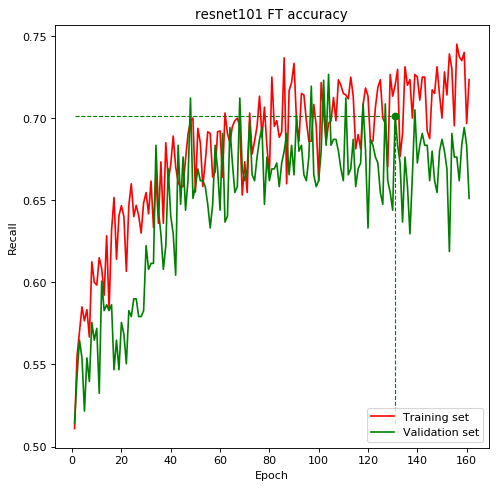

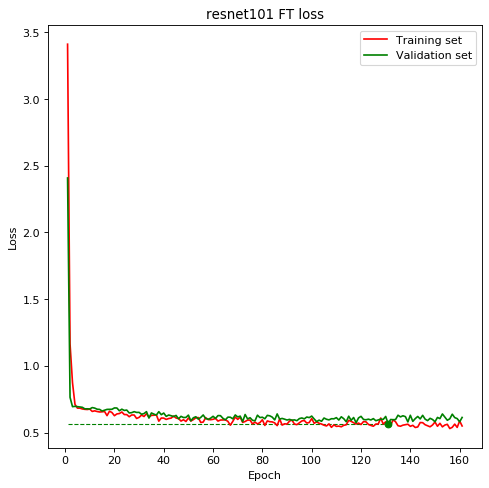

In [46]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [15]:
resnet101_mass_benign_or_malignant_best_Nadam = create_resnet101(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet101_mass_benign_or_malignant_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet101_mass_benign_or_malignant_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_resnet101_mass_benign_or_malignant_best_Nadam = resnet101_mass_benign_or_malignant_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 3.3704 - recall: 0.5254
Epoch 00001: val_loss improved from inf to 0.81158, saving model to ../model/resnet101_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 17s 3s/step - loss: 3.0635 - recall: 0.5167 - val_loss: 0.8116 - val_recall: 0.5180
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8089 - recall: 0.5918
Epoch 00002: val_loss improved from 0.81158 to 0.78417, saving model to ../model/resnet101_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 11s 2s/step - loss: 0.7925 - recall: 0.6016 - val_loss: 0.7842 - val_recall: 0.5108
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7010 - recall: 0.6038
Epoch 00003: val_loss improved from 0.78417 to 0.71412, sav

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5998 - recall: 0.6970
Epoch 00028: val_loss did not improve from 0.61596
5/5 [==============================] - 11s 2s/step - loss: 0.5990 - recall: 0.6950 - val_loss: 0.6522 - val_recall: 0.6403
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6066 - recall: 0.6934
Epoch 00029: val_loss did not improve from 0.61596
5/5 [==============================] - 11s 2s/step - loss: 0.6124 - recall: 0.6859 - val_loss: 0.6543 - val_recall: 0.6727
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5770 - recall: 0.6973
Epoch 00030: val_loss did not improve from 0.61596
5/5 [==============================] - 11s 2s/step - loss: 0.5821 - recall: 0.6984 - val_loss: 0.6752 - val_recall: 0.6151
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6088 - recall: 0.6843
Epoch 00031: val_loss did not improve from 0.61596
5/5 [==============================] - 11s 2s/step - loss: 

In [17]:
models.save_model(resnet101_mass_benign_or_malignant_best_Nadam, '../model/resnet101_mass_benign_or_malignant_end_Nadam.h5')

In [18]:
tra_loss_fe = history_resnet101_mass_benign_or_malignant_best_Nadam.history['loss']
tra_acc_fe = history_resnet101_mass_benign_or_malignant_best_Nadam.history['recall']
val_loss_fe = history_resnet101_mass_benign_or_malignant_best_Nadam.history['val_loss']
val_acc_fe = history_resnet101_mass_benign_or_malignant_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet101_mass_benign_or_malignant = models.load_model('../model/resnet101_mass_benign_or_malignant_best_Nadam.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet101 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 benign or malignant

Epoch [end]: 45
Epoch [opt]: 15
Valid recall [end]: 0.6583
Valid recall [opt]: 0.6511
Test recall [end]:  0.6699
Test recall [opt]:  0.6340
Valid loss [end]: 0.6469
Valid loss [opt]: 0.6160
Test loss [end]:  0.6299
Test loss [opt]:  0.6409


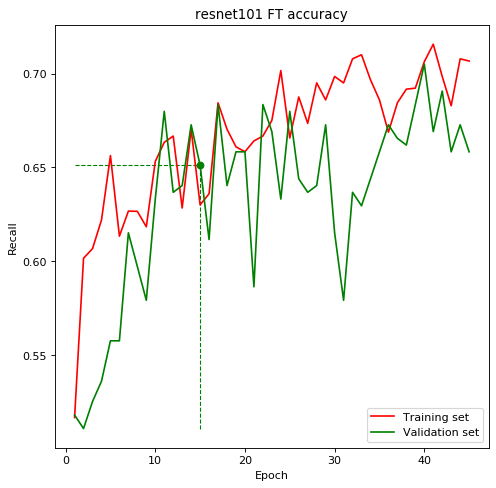

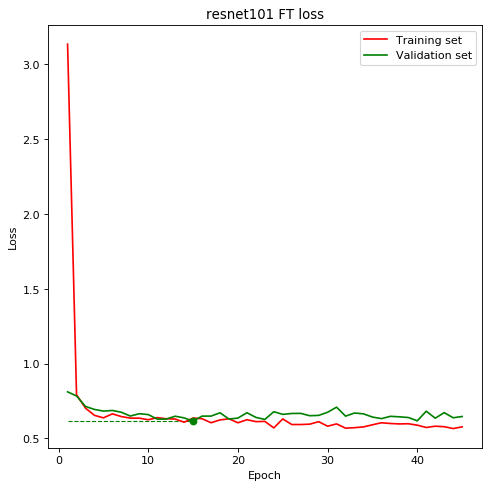

In [19]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [20]:
resnet101_mass_benign_or_malignant_fine_RMSprop = models.load_model('../model/resnet101_mass_benign_or_malignant_best_RMSprop.h5')

for layer in resnet101_mass_benign_or_malignant_fine_RMSprop.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet101_mass_benign_or_malignant_fine_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet101_mass_benign_or_malignant_fine_RMSprop.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [21]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [22]:
history_fit = resnet101_mass_benign_or_malignant_fine_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6356 - recall: 0.6843
Epoch 00001: val_loss improved from inf to 0.65514, saving model to ../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 14s 3s/step - loss: 0.6538 - recall: 0.6783 - val_loss: 0.6551 - val_recall: 0.6871
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6142 - recall: 0.7182
Epoch 00002: val_loss improved from 0.65514 to 0.64266, saving model to ../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6048 - recall: 0.7200 - val_loss: 0.6427 - val_recall: 0.6835
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5868 - recall: 0.7012
Epoch 00003: val_loss did not improve from 0.64266
5/5 [==============================] - 11s 2s/step - loss: 0.5782 - re

4/5 [=======================>......] - ETA: 1s - loss: 0.6739 - recall: 0.6547
Epoch 00058: val_loss did not improve from 0.60542
5/5 [==============================] - 11s 2s/step - loss: 0.6647 - recall: 0.6617 - val_loss: 0.6490 - val_recall: 0.6547
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6397 - recall: 0.6992
Epoch 00059: val_loss did not improve from 0.60542
5/5 [==============================] - 10s 2s/step - loss: 0.6382 - recall: 0.6917 - val_loss: 0.6389 - val_recall: 0.6511
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6651 - recall: 0.6970
Epoch 00060: val_loss did not improve from 0.60542
5/5 [==============================] - 10s 2s/step - loss: 0.6425 - recall: 0.7033 - val_loss: 0.6343 - val_recall: 0.6727
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6110 - recall: 0.7012
Epoch 00061: val_loss did not improve from 0.60542
5/5 [==============================] - 10s 2s/step - loss: 0.6257 - reca

Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6776 - recall: 0.6822
Epoch 00089: val_loss did not improve from 0.59840
5/5 [==============================] - 10s 2s/step - loss: 0.6546 - recall: 0.6883 - val_loss: 0.6358 - val_recall: 0.6906
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6029 - recall: 0.7090
Epoch 00090: val_loss did not improve from 0.59840
5/5 [==============================] - 10s 2s/step - loss: 0.6131 - recall: 0.7083 - val_loss: 0.6679 - val_recall: 0.6583
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6244 - recall: 0.7051
Epoch 00091: val_loss did not improve from 0.59840
5/5 [==============================] - 10s 2s/step - loss: 0.6301 - recall: 0.7017 - val_loss: 0.6389 - val_recall: 0.6799
Epoch 92/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5941 - recall: 0.7266
Epoch 00092: val_loss did not improve from 0.59840
5/5 [==============================] - 11s 2s/step - loss: 

In [23]:
models.save_model(resnet101_mass_benign_or_malignant_fine_RMSprop, '../model/resnet101_mass_benign_or_malignant_fine_RMSprop_end.h5')

In [24]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_mass_benign_or_malignant_fine_RMSprop = models.load_model('../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)

print("resnet101 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 Fine Tuning

Epoch [end]: 97
Epoch [opt]: 67
Valid recall [end]: 0.6978
Valid recall [opt]: 0.7086
Test recall [end]:  0.6569
Test recall [opt]:  0.6569
Valid loss [end]: 0.6640
Valid loss [opt]: 0.5984
Test loss [end]:  0.6263
Test loss [opt]:  0.6263


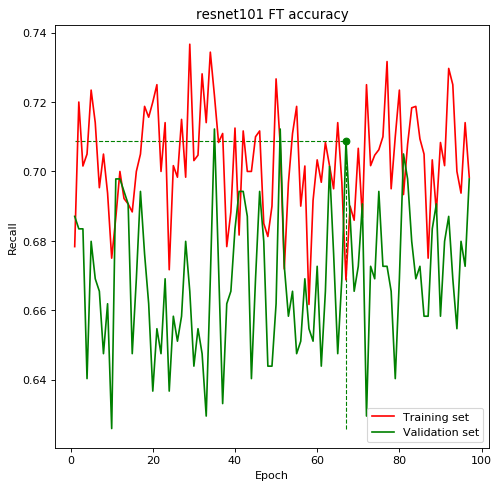

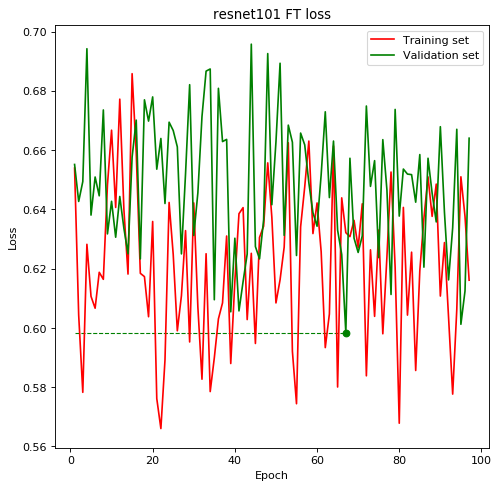

In [25]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [26]:
resnet101_mass_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best.h5')

for layer in resnet101_mass_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet101_mass_benign_or_malignant_fine_RMSprop2.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet101_mass_benign_or_malignant_fine_RMSprop2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [27]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [28]:
history_fit = resnet101_mass_benign_or_malignant_fine_RMSprop2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6558 - recall: 0.6801
Epoch 00001: val_loss improved from inf to 0.61808, saving model to ../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best2.h5
5/5 [==============================] - 14s 3s/step - loss: 0.6492 - recall: 0.6850 - val_loss: 0.6181 - val_recall: 0.6619
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6463 - recall: 0.7267
Epoch 00002: val_loss did not improve from 0.61808
5/5 [==============================] - 10s 2s/step - loss: 0.6212 - recall: 0.7333 - val_loss: 0.6845 - val_recall: 0.6835
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6503 - recall: 0.6992
Epoch 00003: val_loss did not improve from 0.61808
5/5 [==============================] - 11s 2s/step - loss: 0.6236 - recall: 0.7078 - val_loss: 0.6425 - val_recall: 0.6871
Epoch 4/300
4/5 [===============

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6683 - recall: 0.6641
Epoch 00030: val_loss did not improve from 0.60837
5/5 [==============================] - 11s 2s/step - loss: 0.6472 - recall: 0.6656 - val_loss: 0.6918 - val_recall: 0.6403
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5756 - recall: 0.7148
Epoch 00031: val_loss did not improve from 0.60837
5/5 [==============================] - 11s 2s/step - loss: 0.6110 - recall: 0.7133 - val_loss: 0.6386 - val_recall: 0.6835
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6403 - recall: 0.7055
Epoch 00032: val_loss did not improve from 0.60837
5/5 [==============================] - 10s 2s/step - loss: 0.6209 - recall: 0.7117 - val_loss: 0.6786 - val_recall: 0.6547
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5964 - recall: 0.7140
Epoch 00033: val_loss improved from 0.60837 to 0.59896, saving model to ../model/resnet101_mass_benign_or_mali

Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6268 - recall: 0.6895
Epoch 00061: val_loss did not improve from 0.59896
5/5 [==============================] - 11s 2s/step - loss: 0.6116 - recall: 0.7016 - val_loss: 0.6593 - val_recall: 0.6835
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6027 - recall: 0.7246
Epoch 00062: val_loss did not improve from 0.59896
5/5 [==============================] - 11s 2s/step - loss: 0.6246 - recall: 0.7188 - val_loss: 0.6676 - val_recall: 0.6439
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6452 - recall: 0.7034
Epoch 00063: val_loss did not improve from 0.59896
5/5 [==============================] - 11s 2s/step - loss: 0.6190 - recall: 0.7133 - val_loss: 0.6393 - val_recall: 0.6978
Epoch 00063: early stopping


In [29]:
models.save_model(resnet101_mass_benign_or_malignant_fine_RMSprop2, '../model/resnet101_mass_benign_or_malignant_fine_RMSprop_end2.h5')

In [30]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_mass_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best2.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)

print("resnet101 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 Fine Tuning

Epoch [end]: 63
Epoch [opt]: 33
Valid recall [end]: 0.6978
Valid recall [opt]: 0.6691
Test recall [end]:  0.6569
Test recall [opt]:  0.6569
Valid loss [end]: 0.6393
Valid loss [opt]: 0.5990
Test loss [end]:  0.6263
Test loss [opt]:  0.6263


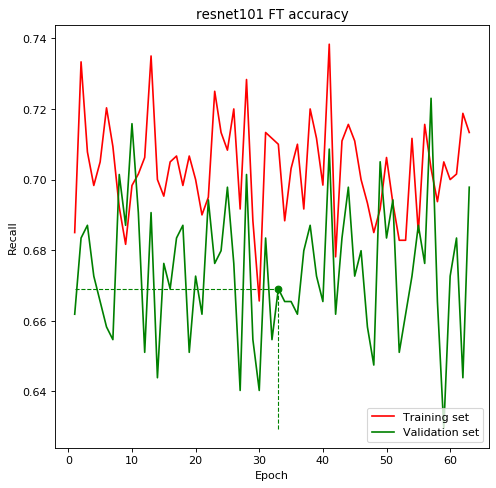

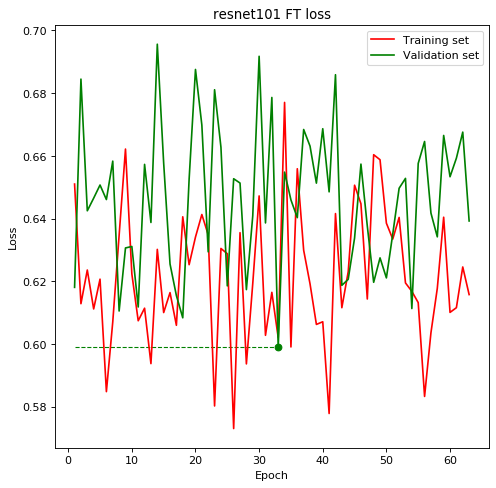

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [15]:
resnet101_mass_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best2.h5')

for layer in resnet101_mass_benign_or_malignant_fine_RMSprop3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet101_mass_benign_or_malignant_fine_RMSprop3.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet101_mass_benign_or_malignant_fine_RMSprop3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [17]:
history_fit = resnet101_mass_benign_or_malignant_fine_RMSprop3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6012 - recall: 0.7227
Epoch 00001: val_loss improved from inf to 0.62241, saving model to ../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 15s 3s/step - loss: 0.6089 - recall: 0.7109 - val_loss: 0.6224 - val_recall: 0.7050
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6545 - recall: 0.6855
Epoch 00002: val_loss did not improve from 0.62241
5/5 [==============================] - 10s 2s/step - loss: 0.6559 - recall: 0.6875 - val_loss: 0.6497 - val_recall: 0.6331
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6422 - recall: 0.6928
Epoch 00003: val_loss did not improve from 0.62241
5/5 [==============================] - 10s 2s/step - loss: 0.6368 - recall: 0.6

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6092 - recall: 0.6934
Epoch 00029: val_loss did not improve from 0.57209
5/5 [==============================] - 11s 2s/step - loss: 0.6118 - recall: 0.6938 - val_loss: 0.6211 - val_recall: 0.6403
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5976 - recall: 0.7422
Epoch 00030: val_loss did not improve from 0.57209
5/5 [==============================] - 10s 2s/step - loss: 0.5805 - recall: 0.7450 - val_loss: 0.6185 - val_recall: 0.6871
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5984 - recall: 0.6992
Epoch 00031: val_loss did not improve from 0.57209
5/5 [==============================] - 11s 2s/step - loss: 0.6048 - recall: 0.6969 - val_loss: 0.6336 - val_recall: 0.6978
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6135 - recall: 0.7031
Epoch 00032: val_loss did not improve from 0.57209
5/5 [==============================] - 11s 2s/step - loss: 

In [18]:
models.save_model(resnet101_mass_benign_or_malignant_fine_RMSprop3, '../model/resnet101_mass_benign_or_malignant_fine_RMSprop_end3.h5')

In [19]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_mass_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/resnet101_mass_benign_or_malignant_fine_RMSprop_best3.h5')
test_loss_fe, test_acc_fe = resnet101_mass_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_mass_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)

print("resnet101 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 Fine Tuning

Epoch [end]: 51
Epoch [opt]: 21
Valid recall [end]: 0.6403
Valid recall [opt]: 0.6799
Test recall [end]:  0.6569
Test recall [opt]:  0.6569
Valid loss [end]: 0.6381
Valid loss [opt]: 0.5721
Test loss [end]:  0.6263
Test loss [opt]:  0.6263


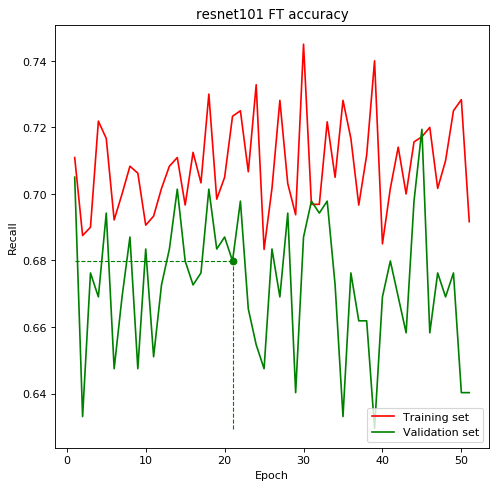

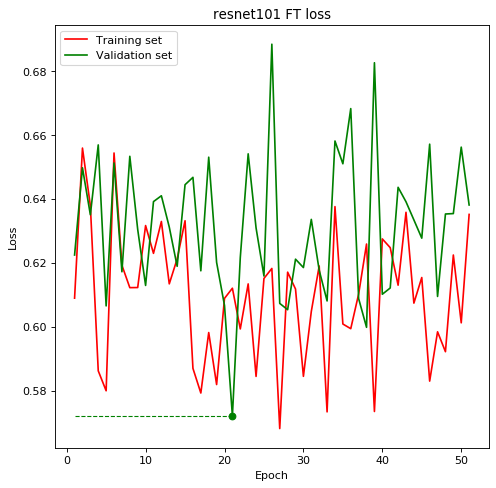

In [20]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();